In [15]:

from util import *

import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
file_path = "./MNIST"
batch_size = 4

## Data

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.MNIST(root='../data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [20]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([6, 9, 9, 3])
Batch shape:  torch.Size([4, 1, 28, 28])


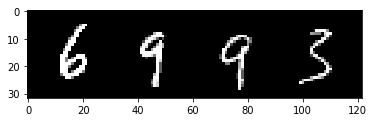

In [21]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

## Models

### Logistic Regression

In [22]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = nn.Linear(28*28, 10)

    def forward(self, x):
        y_pred = F.log_softmax(self.linear1(x.view(batch_size, -1)), -1)
        return y_pred

###   Two-layer neural network 

In [23]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(batch_size, -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

## Train

In [25]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [26]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [27]:
print_every = 4
n_epochs = 10
tr_loss = {}
tr_loss['sgd'] = {}
val_loss = {}
val_loss['sgd'] = {}
lrs = [0.05, 0.01, 0.005]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [28]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            #'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             'times' : state1['times'] + state2['times']
             }
    return states

### LR

In [29]:
for lr in lrs:
    model = LR()
    print("SGD  lr={}, momentum=0. :".format(lr))
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
    tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/LR_' + str(lr))

SGD  lr=0.05, momentum=0. :
Epoch 0, training loss 1.1780855681594937, time passed 0m 14s
Validation loss 0.8898215400663054
Epoch 4, training loss 0.9854220882919312, time passed 1m 28s
Validation loss 0.7956740856658655
Epoch 8, training loss 0.9356644755600687, time passed 2m 35s
Validation loss 1.1033360945425692
SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.41744157781241836, time passed 0m 15s
Validation loss 0.34177317562452464
Epoch 4, training loss 0.32298255702170864, time passed 1m 31s
Validation loss 0.32006483330306096
Epoch 8, training loss 0.30996284269243574, time passed 2m 45s
Validation loss 0.34814489637442086
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.4128899209297754, time passed 0m 15s
Validation loss 0.3270309631392942
Epoch 4, training loss 0.2971736393977773, time passed 1m 29s
Validation loss 0.30530539177935545
Epoch 8, training loss 0.2849366374806503, time passed 2m 43s
Validation loss 0.2893698387459011


In [ ]:
l_0 = 2
model = LR()
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/LR_sug')

Epoch 0, training loss 0.46133514287144944, time passed 0m 27s
Validation loss 0.49703192665142754


### FC

In [0]:
n_epochs = 12

In [0]:
for lr in lrs:
    model = FC()
    print("SGD  lr={}, momentum=0. :".format(lr))
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
    tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './MNIST/FC_' + str(lr))

SGD  lr=0.05, momentum=0. :
Epoch 0, training loss 0.2366863005871361, time passed 0m 29s
Validation loss 0.11924165910008008
Epoch 4, training loss 0.036543241790046185, time passed 2m 44s
Validation loss 0.02659412257774187
Epoch 8, training loss 0.009252302931265622, time passed 4m 57s
Validation loss 0.007337128495894416
SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.390318907132868, time passed 0m 28s
Validation loss 0.21850812987732113
Epoch 4, training loss 0.07997714770486358, time passed 2m 43s
Validation loss 0.06550830985610355
Epoch 8, training loss 0.04263166229681311, time passed 4m 59s
Validation loss 0.0345691220396728
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.49476544181125587, time passed 0m 28s
Validation loss 0.2863557395032906
Epoch 4, training loss 0.13017870467198542, time passed 2m 44s
Validation loss 0.11114349794313609
Epoch 8, training loss 0.0772063676231337, time passed 4m 57s
Validation loss 0.06647039221731384


In [0]:
l_0 = 2
model = FC()
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/FC_sug')

Epoch 0, training loss 0.2193387469148363, time passed 0m 59s
Validation loss 0.11775196808452021
Epoch 4, training loss 0.03766450093525402, time passed 5m 24s
Validation loss 0.030662210186940927
Epoch 8, training loss 0.017794447657136097, time passed 9m 37s
Validation loss 0.013901273798232293
